### Global Parameters

In [7]:
num_data=2048
batch_size=512
num_val=512
iter=10
iter_start=0
iter_train=500
depth_list=[3]
scheme='QCDQML' 
#QCNN Scheme ('non_DQML','QCDQML','QCDQML_nonbiased','QCDQML_2m,'CCDQML','NCDQML')
#QCDQML_nonbiased: single measure QCDQML: single measure with bias QCDQML_2m: double measure with bias
dataset='Dataset1' #Pickled Dataset


In [8]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
pi=np.pi

### Circuit Blocks

In [9]:
# Ising Block used in Embedding and Convolutional layer
# Hadamard and RZ in each qubit and ZZ with neighboring qubit
# number of qubit = number of parameter
# th_i for ith  RZ
# (1/2)(pi-th_1)(pi-th_2) in ZZ

def Ising(weights,wires,depth): #size of circuit = number of parameter
    size=len(wires)
    if size==2: #for 2 qubit Ising, only one ZZ interaction is required.
        for d in range(depth):
            [qml.Hadamard(wires=w) for w in wires]
            [qml.RZ(weights[size*d+i],wires=wires[i]) for i in range(size)]
            qml.IsingZZ(0.5*(np.pi-weights[d*size])*(np.pi-weights[d*size+1]),wires=[wires[0],wires[1]])
    else:
        for d in range(depth):
            [qml.Hadamard(wires=w) for w in wires]
            [qml.RZ(weights[size*d+i],wires=wires[i]) for i in range(size)]
            [qml.IsingZZ(0.5*(np.pi-weights[size*d+i])*(np.pi-weights[size*d+(i+1)%size]),wires=[wires[i],wires[(i+1)%size]]) for i in range(size)]

def Convolution(weights,wires,depth): 
    size=len(wires)
    for d in range(depth):
        [qml.Hadamard(wires=w) for w in wires]
        for i in range(int(size/2)):
            qml.CZ(wires=[wires[i*2],wires[(i*2+1)%size]])
        [qml.RX(weights[size*d+i],wires=wires[i]) for i in range(size)]

        if size!=2: 
            [qml.Hadamard(wires=w) for w in wires]
            for i in range(int(size/2)):
                qml.CZ(wires=[wires[i*2+1],wires[(i*2+2)%size]])
            [qml.RX(weights[size*d+i],wires=wires[i]) for i in range(size)]



# Pooling Circuit
def Pooling(weights,m_qubit,t_qubit):
    m_f=qml.measure(m_qubit)
    qml.cond(m_f==0,qml.RZ)(weights[0],wires=t_qubit)
    qml.cond(m_f==0,qml.RX)(weights[1],wires=t_qubit)
    qml.cond(m_f==1,qml.RZ)(weights[2],wires=t_qubit)
    qml.cond(m_f==1,qml.RX)(weights[3],wires=t_qubit)

def Convolution_Pooling_CCDQML(weights,wires_1,wires_2,depth):
        qml.Barrier(wires=wires_1,only_visual=True)
        qml.Barrier(wires=wires_2,only_visual=True)
        size=len(wires_1)
        wires=[wires_1,wires_2]
        for i in range(2):
            Convolution(weights[i*depth*size:(i+1)*depth*size],wires[i],depth)
        qml.Barrier(wires=wires_1,only_visual=True)
        qml.Barrier(wires=wires_2,only_visual=True)
        poolingweights=weights[2*depth*size:]
        for j in range(int(size/2)):
            Pooling(poolingweights[8*j:8*j+4],wires_1[j*2],wires_2[j*2+1])
            Pooling(poolingweights[8*j+4:8*j+8],wires_2[j*2],wires_1[j*2+1])

    #total parameters: 2*(depth+2)*(size per module)

def Convolution_Pooling_NCDQML(weights,wires_1,wires_2,depth):
        qml.Barrier(wires=wires_1,only_visual=True)
        qml.Barrier(wires=wires_2,only_visual=True)
        size=len(wires_1)
        wires=[wires_1,wires_2]
        for i in range(2):
            Convolution(weights[i*depth*size:(i+1)*depth*size],wires[i],depth)
        poolingweights=weights[2*depth*size:]
        qml.Barrier(wires=wires_1,only_visual=True)
        qml.Barrier(wires=wires_2,only_visual=True)        
        for j in range(int(size/2)):
            Pooling(poolingweights[8*j:8*j+4],wires_1[j*2],wires_1[j*2+1])
            Pooling(poolingweights[8*j+4:8*j+8],wires_2[j*2],wires_2[j*2+1])
    #total parameters: 2*(depth+2)*(size per module)

def Convolution_Pooling_Full(weights,wires,depth):
    qml.Barrier(wires=wires,only_visual=True)
    size=len(wires)
    Convolution(weights[:depth*size],wires,depth)
    qml.Barrier(wires=wires,only_visual=True)
    poolingweights=weights[depth*size:]
    for j in range(int(size/2)):
       Pooling(poolingweights[4*j:4*j+4],wires[j*2],wires[j*2+1])
    #total parameters: (depth+2)*size
    

def RandParam(num_para):
    P=[]
    for i in range(num_para):
        P.append(2*np.pi*np.random.rand())
    return np.array(P)

### Loss Function / Accuracy

In [10]:
#Loss function and Accuracy

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    
    return loss

def accuracy_Expval(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss



### Cost

In [11]:
#Cost subject to optimize

def cost_squareloss(weights, features, labels): 
    predictions = [circuit(weights, f) for f in features]
    return loss(labels,predictions)

def learnedmeasure_squareloss(weights,bias, features,labels):
    predictions=[]
    for f in features:
        outcome=circuit(weights,f)
        predictions.append(bias[0]*outcome[0]+bias[1]*outcome[1]+bias[2]*outcome[2]+bias[3]*outcome[3])
    return loss(labels,predictions)

def biased_onemeasured_squareloss(weights,bias,features,labels):
    predictions=[]
    for f in features:
        outcome=circuit(weights,f)
        predictions.append(bias[0]*outcome[0]+bias[1]*outcome[1])
    return loss(labels,predictions)

### Circuit

In [12]:
loss = square_loss
accuracy=accuracy_Expval
binary=True
cost=learnedmeasure_squareloss
if scheme == 'QCDQML':
    cost= biased_onemeasured_squareloss
if scheme=='QCDQML_nonbiased' or scheme=='non_DQML':
    cost=cost_squareloss

with open(dataset, 'rb') as f:
    X=pickle.load(f)

In [13]:
if scheme=='non_DQML':
    dev1=qml.device('default.qubit',wires=4)
    @qml.qnode(dev1)
    def circuit_4(weights,data_in):
        for i in range(2):
            Ising(data_in[i*4:(i+1)*4],list(range(4)),1)

        Convolution_Pooling_Full(weights[0:(depth+2)*4],[0,1,2,3],depth)
        Convolution_Pooling_Full(weights[(depth+2)*4:(depth+2)*6],[1,3],depth)

        return qml.expval(qml.PauliZ(3))


In [14]:
if scheme=='NCDQML' or scheme=='CCDQML':
    dev2=qml.device('default.qubit',wires=8)
    @qml.qnode(dev2)
    def circuit_44(weights,data_in):
        Ising(data_in[:4],[0,1,2,3],1)
        Ising(data_in[4:],[4,5,6,7],1)          

        if scheme=='NCDQML':
            Convolution_Pooling_NCDQML(weights[:(depth+2)*8],[0,1,2,3],[4,5,6,7],depth)
            Convolution_Pooling_NCDQML(weights[(depth+2)*8:(depth+2)*12],[1,3],[5,7],depth)
        if scheme=='CCDQML':
            Convolution_Pooling_CCDQML(weights[:2*(depth+2)*4],[0,1,2,3],[4,5,6,7],depth)
            Convolution_Pooling_CCDQML(weights[(depth+2)*8:(depth+2)*12],[1,3],[5,7],depth)

        return qml.probs(wires=[3,7])

In [15]:
if scheme=='QCDQML' or scheme == 'QCDQML_nonbiased' or scheme == 'QCDQML_2m':
    dev5=qml.device('default.qubit',wires=8)
    @qml.qnode(dev5)
    def circuit_8(weights,data_in):
        Ising(data_in,list(range(8)),1)
        Convolution_Pooling_Full(weights[:(depth+2)*8],list(range(8)),depth)
        Convolution_Pooling_Full(weights[(depth+2)*8:(depth+2)*12],[1,3,5,7],depth)
        if scheme == 'QCDQML_nonbiased' :
            Convolution_Pooling_Full(weights[(depth+2)*12:(depth+2)*14],[3,7],depth)
            return qml.expval(qml.PauliZ(7))
        elif scheme == 'QCDQML':
            Convolution_Pooling_Full(weights[(depth+2)*12:(depth+2)*14],[3,7],depth)
            return qml.probs(wires=[7])
        elif scheme == 'QCDQML_2m':
            return qml.probs(wires=[3,7])

    
    

In [16]:
if scheme =='NCDQML' or scheme  == 'CCDQML':
    circuit=circuit_44
    num_qubits=8

elif scheme =='non_DQML':
    circuit=circuit_4
    num_qubits=4

elif scheme =='QCDQML' or scheme == 'QCDQML_2m' or scheme == 'QCDQML_nonbiased':
    circuit=circuit_8
    num_qubits=8
    
module=int(num_qubits/2)

### Main Function

In [17]:
def QCNN(iteration,train_validation_set):
    opt=qml.AdamOptimizer()
    start_time=time.time()
    feats_train=train_validation_set[0]
    Y_train=np.array(train_validation_set[1])
    feats_val=train_validation_set[2][:num_val]
    Y_val=train_validation_set[3][:num_val]
    num_train=train_validation_set[4]
    cost_list=[]
    acc_val_list=[]
    if scheme=='NCDQML' or scheme== 'CCDQML':
        weights=RandParam((depth+2)*12)
    if scheme=='non_DQML':
        weights=RandParam((depth+2)*6)  
    if scheme=='QCDQML' or scheme == 'QCDQML_nonbiased':
        weights=RandParam((depth+2)*14)
    if scheme == 'QCDQML_2m':
        weights=RandParam((depth+2)*12)
    bias=np.array([1,-1,-1,1])
    if scheme == 'QCDQML':
        bias=np.array([1,-1])
    for it in range(iteration):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        feats_train_batch = feats_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        if scheme == 'non_DQML' or scheme == 'QCDQML_nonbiased':
            opt_result = opt.step_and_cost(cost, weights,  feats_train_batch, Y_train_batch)

            weights, _, _ = opt_result[0]
            predictions_val = np.sign([circuit(weights, f) for f in feats_val])
            acc_val = accuracy(Y_val, predictions_val)


        elif scheme=='NCDQML' or scheme== 'CCDQML' or scheme== 'QCDQML_2m':
            opt_result = opt.step_and_cost(cost,weights,bias,feats_train_batch, Y_train_batch)
            weights,bias,_,_=opt_result[0]
            predictions_val=[]
            for f in feats_val:
                outcome=circuit(weights,f)
                predictions_val.append(np.sign(bias[0]*outcome[0]+bias[1]*outcome[1]+bias[2]*outcome[2]+bias[3]*outcome[3]))
            acc_val = accuracy(Y_val,predictions_val)

        elif scheme=='QCDQML':
            opt_result = opt.step_and_cost(cost,weights,bias,feats_train_batch, Y_train_batch)
            weights,bias,_,_=opt_result[0]
            predictions_val=[]
            for f in feats_val:
                outcome=circuit(weights,f)
                predictions_val.append(np.sign(bias[0]*outcome[0]+bias[1]*outcome[1]))
            acc_val = accuracy(Y_val,predictions_val)

        cost_list.append(opt_result[1])
        acc_val_list.append(acc_val)    

        if it%10 ==0:
            print('(',it,') loss:',np.round(opt_result[1],2), 'accuracy:',np.round(acc_val,2))

    print('---final---')
    print('loss:',np.round(opt_result[1],2), 'accuracy:',np.round(acc_val,2))
    print("%s mins" % round((time.time() - start_time)/60,1))
    print('bias:',bias)

    plt.title('depth='+str(depth)+', iter='+str(i+1))
    plt.plot(cost_list,'--o',label='Loss')
    plt.plot(acc_val_list,'--o',label='Accuracy')

    plt.xlabel("iterations")
    plt.ylabel("Loss / Accuracy")
    plt.legend(loc=(0.75,1.1))
    plt.ylim([0,1.2])

    plt.show()

    return cost_list, acc_val_list, weights, bias

# Execution

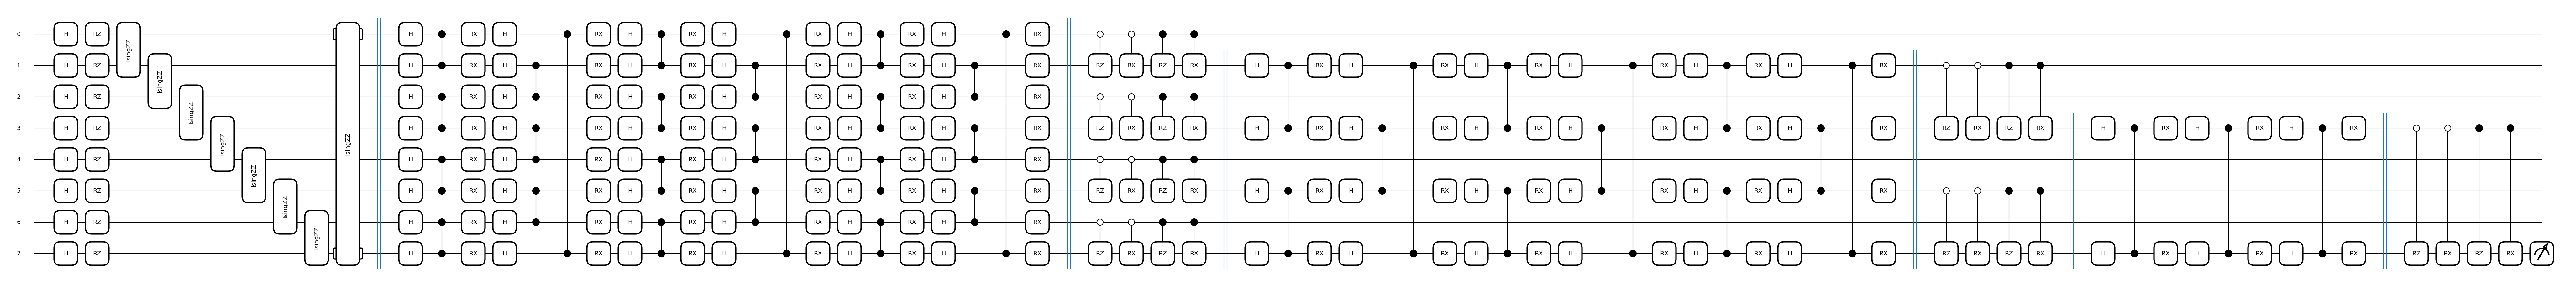

In [18]:
depth=depth_list[0]
if scheme=='NCDQML' or scheme== 'CCDQML':
    weights=RandParam((depth+2)*12)
if scheme=='non_DQML':
    weights=RandParam((depth+2)*6)  
if scheme=='QCDQML' or scheme=='QCDQML_nonbiased':
    weights=RandParam((depth+2)*14)
if scheme == 'QCDQML_2m':
    weights=RandParam((depth+2)*12)
fig, ax = qml.draw_mpl(circuit)(weights,np.random.rand(8))

In [19]:
depth=depth_list[0] 
for i in range(iter_start,iter_start+iter):
    C,A,W,B=QCNN(iter_train,X)
    Result=[C,A,W,B]
    time_stamp=time.strftime('%y%m%d_%H%M_',time.localtime(time.time()))
    with open(scheme+'_'+'depth'+str(depth)+'_'+dataset+'_'+str(i+1), 'wb') as f:
        pickle.dump(Result, f)

KeyboardInterrupt: 